<!-- Shri Krishna: Sharanam Mam
Jai Ambe
Jai Amumaiya
Jai Devudada
Shri Saraswatiyay Nama:
Shri Ganeshay Nama:
Shri Hanumatey Nama: -->

# Importing the necessary libraries

In [ ]:
import numpy as np
import cv2
import os
from google.colab.patches import cv2_imshow

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

from glob import glob
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Focal Loss

In [ ]:
def load_dataset(dataset_path):    
    inputs = sorted(glob(os.path.join(dataset_path, "Input_Images/*")))
    outputs = sorted(glob(os.path.join(dataset_path, "Output_Images/*")))

    train_x, test_x = train_test_split(inputs, test_size = 0.25, random_state = 42)
    train_y, test_y = train_test_split(outputs, test_size = 0.25, random_state = 42)

    return (train_x, train_y), (test_x, test_y)

dataset_path = '/content/'

(train_x, train_y), (test_x, test_y) = load_dataset(dataset_path)

def read_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = img/255.0
    img = img.astype(np.float32)
    img = np.expand_dims(img, axis = -1)
    return img

def preprocess(input_path, output_path):
    def func(input_path, output_path):
        input_path = input_path.decode()
        output_path = output_path.decode()

        x = read_image(input_path)
        y = read_image(output_path)

        return x, y

    input, output = tf.numpy_function(func, [input_path, output_path], [tf.float32, tf.float32])
    input.set_shape([256, 256, 1])
    output.set_shape([256, 256, 1])

    return input, output

def tf_dataset(inputs, outputs, batch = 8):
    dataset = tf.data.Dataset.from_tensor_slices((inputs, outputs))
    dataset = dataset.shuffle(buffer_size = 10000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(2)
    return dataset

def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding = 'same')(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)

    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides = 2, padding = 'same')(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)

    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    # Encoder
    # skip_connection, pooling_layer's output
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # Bridge
    b1 = conv_block(p4, 1024)

    # Decoder
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # Output
    outputs = Conv2D(1, (1, 1), padding = 'same', activation = 'sigmoid')(d4)

    model = Model(inputs, outputs, name = "U-Net")

    return model

# Hyperparameters
input_shape = (256, 256, 1)
batch_size = 8
epochs = 2
lr = 3e-4
model_path = '/content/drive/MyDrive/Shape_Filling_AI/model_FocalLoss.h5'

train_dataset = tf_dataset(train_x, train_y, batch = batch_size)
valid_dataset = tf_dataset(test_x, test_y, batch = batch_size)

model = build_unet(input_shape)
model.compile(
    loss = tf.keras.losses.BinaryFocalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(lr),
    metrics = [
        tf.keras.metrics.MeanIoU(num_classes = 2),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.Precision()
    ]
)
model.summary()

callbacks = [
    ModelCheckpoint(model_path, monitor = "val_loss", verbose = 2),
    ReduceLROnPlateau(monitor="val_loss", patience = 2, factor = 0.1, verbose = 2),
    EarlyStopping(monitor="val_loss", patience = 10)
]

train_steps = len(train_x)//batch_size
if len(train_x) % batch_size != 0:
  train_steps += 1

valid_steps = len(test_x)//batch_size
if len(test_x) % batch_size != 0:
  valid_steps += 1

model.fit(
    train_dataset,
    validation_data = valid_dataset,
    epochs = epochs,
    steps_per_epoch = train_steps,
    validation_steps = valid_steps,
    callbacks = callbacks
)

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

# Cross Entropy Loss

In [ ]:
def load_dataset(dataset_path):    
    inputs = sorted(glob(os.path.join(dataset_path, "Input_Images/*")))
    outputs = sorted(glob(os.path.join(dataset_path, "Output_Images/*")))

    train_x, test_x = train_test_split(inputs, test_size = 0.25, random_state = 42)
    train_y, test_y = train_test_split(outputs, test_size = 0.25, random_state = 42)

    return (train_x, train_y), (test_x, test_y)

dataset_path = '/content/'

(train_x, train_y), (test_x, test_y) = load_dataset(dataset_path)

def read_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = img/255.0
    img = img.astype(np.float32)
    img = np.expand_dims(img, axis = -1)
    return img

def preprocess(input_path, output_path):
    def func(input_path, output_path):
        input_path = input_path.decode()
        output_path = output_path.decode()

        x = read_image(input_path)
        y = read_image(output_path)

        return x, y

    input, output = tf.numpy_function(func, [input_path, output_path], [tf.float32, tf.float32])
    input.set_shape([256, 256, 1])
    output.set_shape([256, 256, 1])

    return input, output

def tf_dataset(inputs, outputs, batch = 8):
    dataset = tf.data.Dataset.from_tensor_slices((inputs, outputs))
    dataset = dataset.shuffle(buffer_size = 10000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(2)
    return dataset

def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding = 'same')(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)

    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides = 2, padding = 'same')(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)

    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    # Encoder
    # skip_connection, pooling_layer's output
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # Bridge
    b1 = conv_block(p4, 1024)

    # Decoder
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # Output
    outputs = Conv2D(1, (1, 1), padding = 'same', activation = 'sigmoid')(d4)

    model = Model(inputs, outputs, name = "U-Net")

    return model

# Hyperparameters
input_shape = (256, 256, 1)
batch_size = 8
epochs = 2
lr = 3e-4
model_path = '/content/drive/MyDrive/Shape_Filling_AI/model_CrossEntropy.h5'

train_dataset = tf_dataset(train_x, train_y, batch = batch_size)
valid_dataset = tf_dataset(test_x, test_y, batch = batch_size)

model = build_unet(input_shape)
model.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(lr),
    metrics = [
        tf.keras.metrics.MeanIoU(num_classes = 2),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.Precision()
    ]
)
model.summary()

callbacks = [
    ModelCheckpoint(model_path, monitor = "val_loss", verbose = 2),
    ReduceLROnPlateau(monitor="val_loss", patience = 2, factor = 0.1, verbose = 2),
    EarlyStopping(monitor="val_loss", patience = 10)
]

train_steps = len(train_x)//batch_size
if len(train_x) % batch_size != 0:
  train_steps += 1

valid_steps = len(test_x)//batch_size
if len(test_x) % batch_size != 0:
  valid_steps += 1

model.fit(
    train_dataset,
    validation_data = valid_dataset,
    epochs = epochs,
    steps_per_epoch = train_steps,
    validation_steps = valid_steps,
    callbacks = callbacks
)

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 256, 256, 64  640         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_36 (BatchN  (None, 256, 256, 64  256        ['conv2d_38[0][0]']              
 ormalization)                  )                                                             

# Testing the predictions on random "difficult" samples

In [ ]:
model_focal_loss = tf.keras.models.load_model('/content/drive/MyDrive/Shape_Filling_AI/model_FocalLoss.h5')
model_cross_entropy = tf.keras.models.load_model('/content/drive/MyDrive/Shape_Filling_AI/model_CrossEntropy.h5')

              Input                         Focal Loss             Cross Entropy Loss           Ground Truth


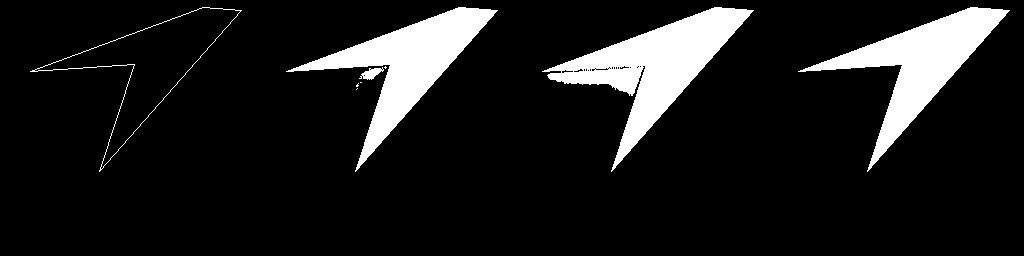

In [ ]:
test_image = np.zeros((256, 256, 1))

p1 = [int(np.random.randint(256, size=1)), int(np.random.randint(256, size=1))]
p2 = [int(np.random.randint(256, size=1)), int(np.random.randint(256, size=1))]
p3 = [int(np.random.randint(256, size=1)), int(np.random.randint(256, size=1))]
p4 = [int(np.random.randint(256, size=1)), int(np.random.randint(256, size=1))]
p5 = [int(np.random.randint(256, size=1)), int(np.random.randint(256, size=1))]

cv2.line(test_image, p1, p2, (255, 255, 255), 1)
cv2.line(test_image, p2, p3, (255, 255, 255), 1)
cv2.line(test_image, p3, p4, (255, 255, 255), 1)
cv2.line(test_image, p4, p5, (255, 255, 255), 1)
cv2.line(test_image, p5, p1, (255, 255, 255), 1) 

test_image_x = test_image.copy()

points = np.array([p1, p2, p3, p4, p5])
ground_truth = cv2.fillPoly(test_image, pts=[points], color=(255, 255, 255)) 

test_image = test_image/255.0
test_image = test_image.astype(np.float32)
test_image = np.expand_dims(test_image, axis = 0)

test_pred_focal_loss = model_focal_loss.predict(test_image)
test_pred_focal_loss = test_pred_focal_loss[0]
test_pred_focal_loss = (test_pred_focal_loss>0.5)*255.0

test_pred_cross_entropy = model_cross_entropy.predict(test_image)
test_pred_cross_entropy = test_pred_cross_entropy[0]
test_pred_cross_entropy = (test_pred_cross_entropy>0.5)*255.0


op = np.concatenate([np.squeeze(test_image_x), np.squeeze(test_pred_focal_loss), 
                     np.squeeze(test_pred_cross_entropy) , np.squeeze(ground_truth)], axis = 1)
print("              Input                         Focal Loss             Cross Entropy Loss           Ground Truth")
cv2_imshow(op)

              Input                         Focal Loss             Cross Entropy Loss           Ground Truth


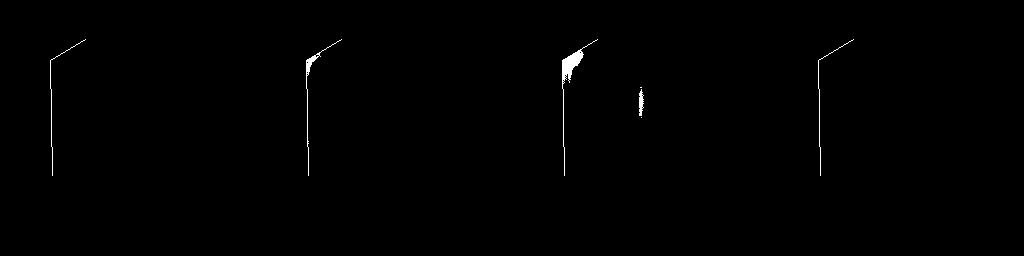

In [ ]:
test_image = np.zeros((256, 256, 1))
p1 = [int(np.random.randint(256, size=1)), int(np.random.randint(256, size=1))]
p2 = [int(np.random.randint(256, size=1)), int(np.random.randint(256, size=1))]
p3 = [int(np.random.randint(256, size=1)), int(np.random.randint(256, size=1))]

cv2.line(test_image, p1, p2, (255, 255, 255), 1)
cv2.line(test_image, p2, p3, (255, 255, 255), 1)

test_image_x = test_image.copy()

ground_truth = test_image

test_image = test_image/255.0
test_image = test_image.astype(np.float32)
test_image = np.expand_dims(test_image, axis = 0)

test_pred_focal_loss = model_focal_loss.predict(test_image)
test_pred_focal_loss = test_pred_focal_loss[0]
test_pred_focal_loss = (test_pred_focal_loss>0.5)*255.0

test_pred_cross_entropy = model_cross_entropy.predict(test_image)
test_pred_cross_entropy = test_pred_cross_entropy[0]
test_pred_cross_entropy = (test_pred_cross_entropy>0.5)*255.0


op = np.concatenate([np.squeeze(test_image_x), np.squeeze(test_pred_focal_loss), 
                     np.squeeze(test_pred_cross_entropy) , np.squeeze(ground_truth)], axis = 1)
print("              Input                         Focal Loss             Cross Entropy Loss           Ground Truth")
cv2_imshow(op)

              Input                         Focal Loss             Cross Entropy Loss           Ground Truth


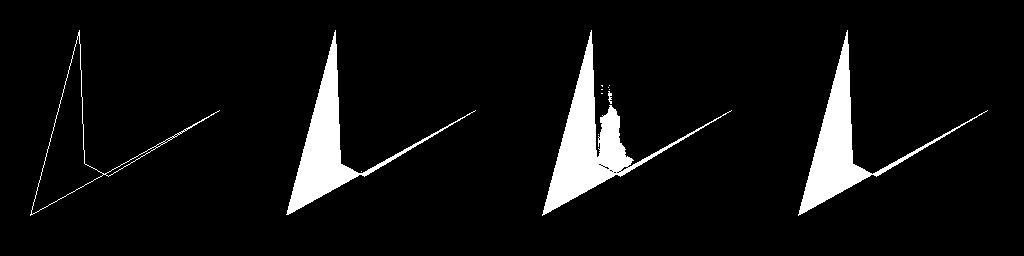

In [ ]:
test_image = np.zeros((256, 256, 1))
p1 = [int(np.random.randint(256, size=1)), int(np.random.randint(256, size=1))]
p2 = [int(np.random.randint(256, size=1)), int(np.random.randint(256, size=1))]
p3 = [int(np.random.randint(256, size=1)), int(np.random.randint(256, size=1))]
p4 = [int(np.random.randint(256, size=1)), int(np.random.randint(256, size=1))]
p5 = [int(np.random.randint(256, size=1)), int(np.random.randint(256, size=1))]

cv2.line(test_image, p1, p2, (255, 255, 255), 1)
cv2.line(test_image, p2, p3, (255, 255, 255), 1)
cv2.line(test_image, p3, p4, (255, 255, 255), 1)
cv2.line(test_image, p4, p5, (255, 255, 255), 1)
cv2.line(test_image, p5, p1, (255, 255, 255), 1) 

test_image_x = test_image.copy()
points = np.array([p1, p2, p3, p4, p5])
ground_truth = cv2.fillPoly(test_image, pts=[points], color=(255, 255, 255)) 

test_image = test_image/255.0
test_image = test_image.astype(np.float32)
test_image = np.expand_dims(test_image, axis = 0)

test_pred_focal_loss = model_focal_loss.predict(test_image)
test_pred_focal_loss = test_pred_focal_loss[0]
test_pred_focal_loss = (test_pred_focal_loss>0.5)*255.0

test_pred_cross_entropy = model_cross_entropy.predict(test_image)
test_pred_cross_entropy = test_pred_cross_entropy[0]
test_pred_cross_entropy = (test_pred_cross_entropy>0.5)*255.0


op = np.concatenate([np.squeeze(test_image_x), np.squeeze(test_pred_focal_loss), 
                     np.squeeze(test_pred_cross_entropy) , np.squeeze(ground_truth)], axis = 1)
print("              Input                         Focal Loss             Cross Entropy Loss           Ground Truth")
cv2_imshow(op)

              Input                         Focal Loss             Cross Entropy Loss           Ground Truth


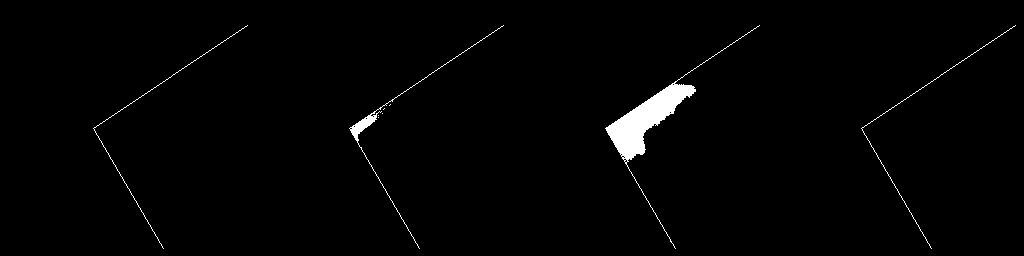

In [ ]:
test_image = np.zeros((256, 256, 1))
p1 = [int(np.random.randint(256, size=1)), int(np.random.randint(256, size=1))]
p2 = [int(np.random.randint(256, size=1)), int(np.random.randint(256, size=1))]
p3 = [int(np.random.randint(256, size=1)), int(np.random.randint(256, size=1))]

cv2.line(test_image, p1, p2, (255, 255, 255), 1)
cv2.line(test_image, p2, p3, (255, 255, 255), 1)

test_image_x = test_image.copy()

ground_truth = test_image

test_image = test_image/255.0
test_image = test_image.astype(np.float32)
test_image = np.expand_dims(test_image, axis = 0)

test_pred_focal_loss = model_focal_loss.predict(test_image)
test_pred_focal_loss = test_pred_focal_loss[0]
test_pred_focal_loss = (test_pred_focal_loss>0.5)*255.0

test_pred_cross_entropy = model_cross_entropy.predict(test_image)
test_pred_cross_entropy = test_pred_cross_entropy[0]
test_pred_cross_entropy = (test_pred_cross_entropy>0.5)*255.0


op = np.concatenate([np.squeeze(test_image_x), np.squeeze(test_pred_focal_loss), 
                     np.squeeze(test_pred_cross_entropy) , np.squeeze(ground_truth)], axis = 1)
print("              Input                         Focal Loss             Cross Entropy Loss           Ground Truth")
cv2_imshow(op)